<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/9_Forecast_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

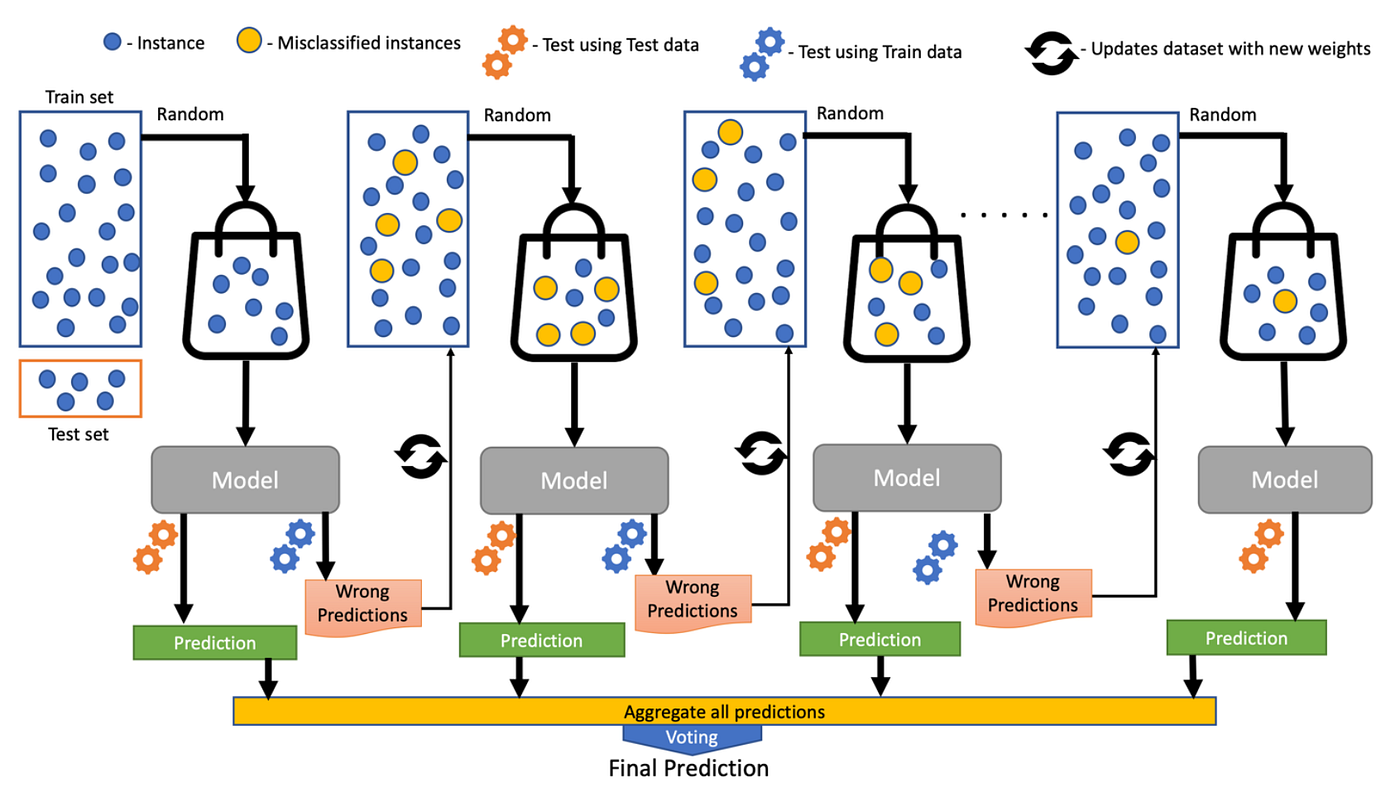

# **¿Qué es XGBoost?**
XGBoost , abreviatura de Extreme Gradient Boosting, es un potente algoritmo de aprendizaje automático que destaca en diversas tareas de modelado predictivo, incluido el pronóstico de series temporales. Es un método de aprendizaje conjunto que combina las predicciones de múltiples modelos débiles ( árboles de decisión ) para crear un modelo predictivo sólido. XGBoost es conocido por su escalabilidad, velocidad y capacidad para manejar relaciones complejas en los datos.

# **Ventajas de XGBoost para el pronóstico de series temporales**
XGBoost ofrece varias ventajas que lo convierten en una excelente opción para el pronóstico de series temporales:

1. *Manejo de relaciones no lineales:* XGBoost puede capturar relaciones no lineales complejas entre las características de entrada y la variable de destino, lo que lo hace adecuado para datos de series de tiempo con patrones complejos.

2. *Importancia de las funciones:* XGBoost proporciona información sobre la importancia de las diferentes funciones, lo que permite a los analistas identificar los factores más influyentes en los datos de series temporales.

3. *Regularización:* XGBoost incorpora técnicas de regularización para evitar el sobreajuste, asegurando que el modelo se generalice bien a datos invisibles.

4. *Manejo de valores faltantes y valores atípicos:* XGBoost puede manejar valores faltantes y valores atípicos en los datos, lo que reduce la necesidad de un preprocesamiento extenso de datos.

# ***Número de Atascos***

El conjunto de datos contiene una serie de tiempo 1136 observaciones del número atascos medidos cada 30 segundos, desde 2024-03-16 06:57:00 hasta 2024-04-15 11:27:00. Dichos mediciones son obtenidos contando la cantidad de vehículos que se van acumulando en una avenida principal de la ciudad de Medellín. Con el fin de realizar una intervención para mejorar la movilidad, se solicita desde la administración municipal realizar cómo será el flujo vehicular en esta avenida en la próxima semana.

In [ ]:
# Primero se debe ejecutar este comando con entorno de Python para conectar con Drive #
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargando las librerías necesarias #
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from matplotlib import pyplot
from numpy import set_printoptions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Cargar datos desde Drive #
series = read_csv('/content/drive/MyDrive/Colab Notebooks/9_atasco.csv', header=0, index_col=0)
values = series.values

In [ ]:
# Visualizar los datos #
series

,num_atascos
Fecha,
2024-03-16 06:57:00,6
2024-03-16 07:27:00,6
2024-03-16 07:57:00,7
2024-03-16 08:27:00,6
2024-03-16 08:57:00,9
...,...
2024-04-15 09:27:00,5
2024-04-15 09:57:00,9
2024-04-15 10:27:00,7


In [ ]:
# Verificar datos nulos
print(series.isnull().sum())

num_atascos    0
dtype: int64


In [ ]:
# Longitud de la serie de tiempo #
series.shape

(1136, 1)

In [ ]:
# Estadísticas descriptivas de las observaciones #
series.describe()

,num_atascos
count,1136.000000
mean,8.498239
std,6.693148
min,1.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,40.000000


In [ ]:
# Cálculo de percentiles adicionales 80,85,90,95,99 #
percentil_80 = np.percentile(series, 80)
percentil_85 = np.percentile(series, 85)
percentil_90 = np.percentile(series, 90)
percentil_95 = np.percentile(series, 95)
percentil_99 = np.percentile(series, 99)
print("Percentil 80:",percentil_80)
print("Percentil 85:",percentil_85)
print("Percentil 90:",percentil_90)
print("Percentil 95:",percentil_95)
print("Percentil 99:",percentil_99)

Percentil 80: 14.0
Percentil 85: 15.0
Percentil 90: 18.0
Percentil 95: 21.0
Percentil 99: 29.65000000000009


In [ ]:
# Analizando las horas donde los atacos están por encima del percentil 95 #
series_95 = series[series['num_atascos'] > percentil_95]
series_95

,num_atascos
Fecha,
2024-03-18 16:27:00,22
2024-03-18 17:57:00,24
2024-03-18 18:27:00,25
2024-03-19 14:27:00,22
2024-03-19 17:27:00,33
2024-03-19 17:57:00,36
2024-03-20 17:57:00,23
2024-03-20 18:27:00,38
2024-03-20 18:57:00,22


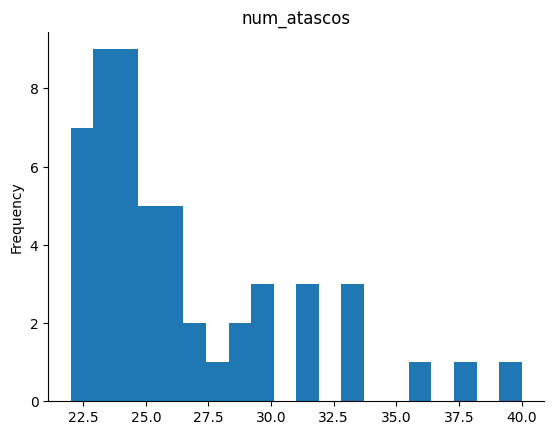

In [ ]:
from matplotlib import pyplot as plt
series_95['num_atascos'].plot(kind='hist', bins=20, title='num_atascos')
plt.gca().spines[['top', 'right',]].set_visible(False)

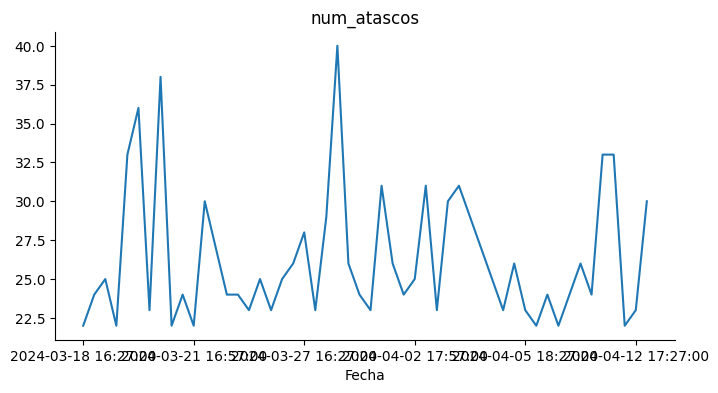

In [ ]:
from matplotlib import pyplot as plt
series_95['num_atascos'].plot(kind='line', figsize=(8, 4), title='num_atascos')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Suavizar los datos con un promedio móvil de 5 min
data_suavizada = series.rolling(window=10).mean()
# Suavizar los datos con un promedio móvil de 10 min
data_suavizada2 = series.rolling(window=20).mean()

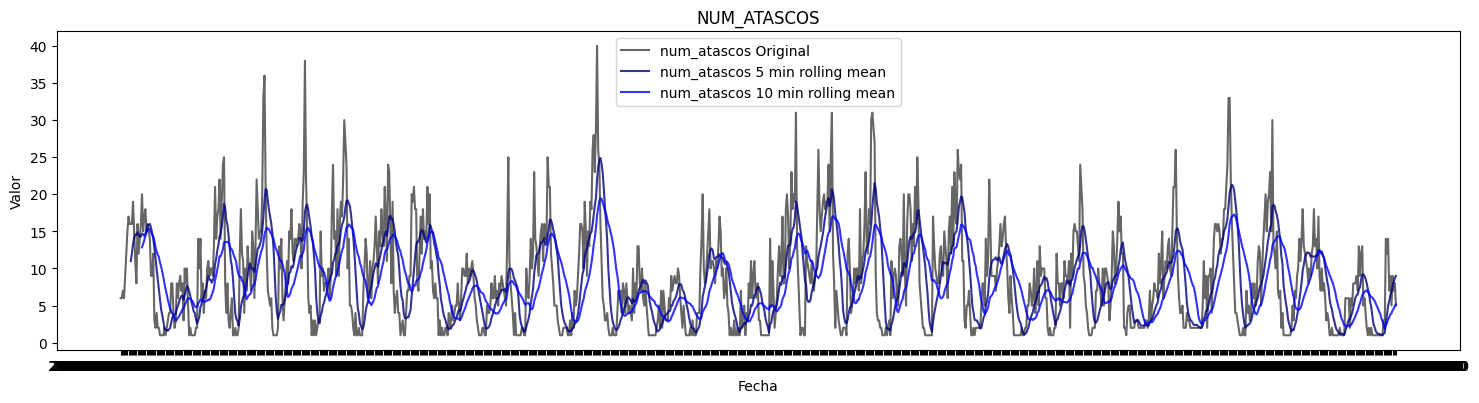

In [ ]:
# Configurando el tamaño del gráfico
plt.figure(figsize=(15, 15))

# Lista de variables para iterar y graficar
variables = ['num_atascos']

for i, var in enumerate(variables, 1):
    plt.subplot(4, 1, i)
    plt.plot(series.index, series[var], label=f'{var} Original', color='black', alpha=0.6)
    plt.plot(data_suavizada.index, data_suavizada[var], label=f'{var} 5 min rolling mean', color='navy', alpha=0.8)
    plt.plot(data_suavizada2.index, data_suavizada2[var], label=f'{var} 10 min rolling mean', color='blue', alpha=0.8)
    plt.title(var.upper())
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()

plt.tight_layout()
plt.show()

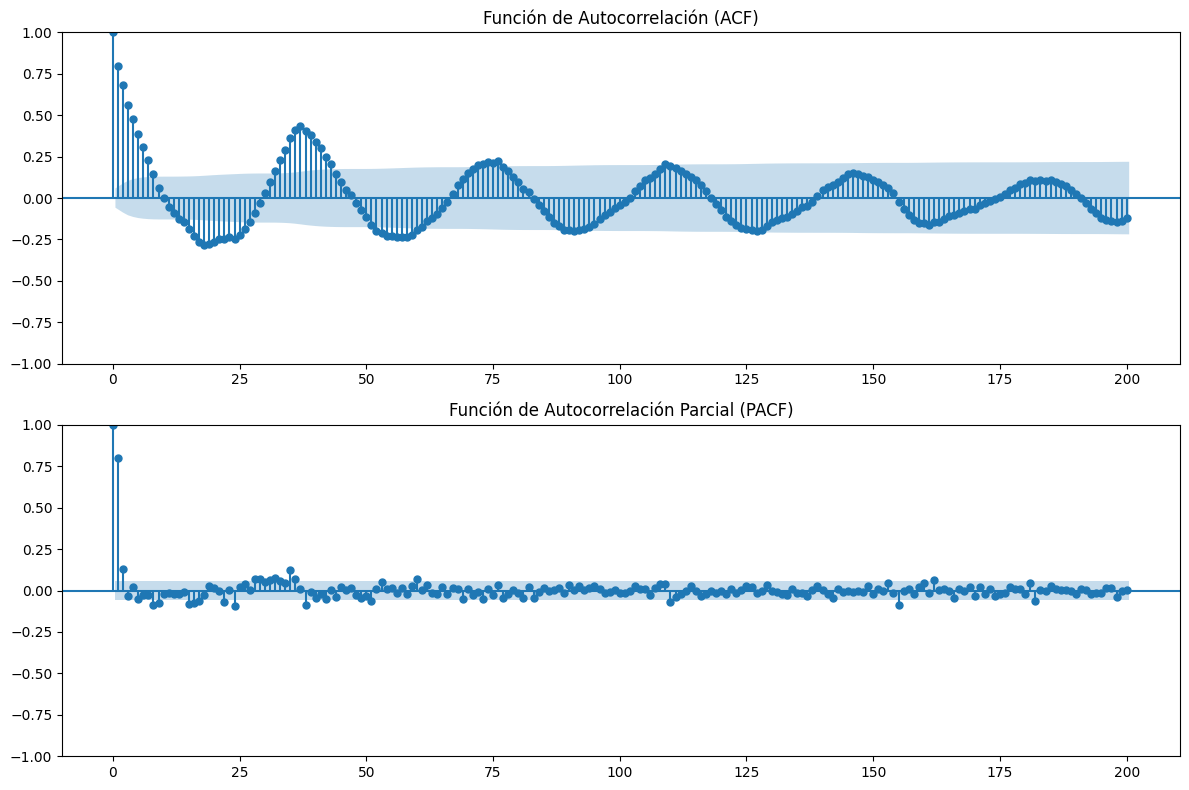

In [ ]:
# Graficar la ACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(series, ax=ax[0], lags=200)
ax[0].set_title('Función de Autocorrelación (ACF)')

# Graficar la PACF
plot_pacf(series, ax=ax[1], lags=200, method='ywm')
ax[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
# Transformando un conjunto de datos de series temporales en un conjunto de datos de aprendizaje supervisado #
def gen_features(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
# transform the time series data into supervised learning
data = gen_features(values, n_in = 36)
data

array([[6., 6., 7., ..., 2., 1., 1.],
       [6., 7., 6., ..., 1., 1., 1.],
       [7., 6., 9., ..., 1., 1., 1.],
       ...,
       [8., 8., 8., ..., 5., 9., 7.],
       [8., 8., 9., ..., 9., 7., 8.],
       [8., 9., 7., ..., 7., 8., 5.]])

In [ ]:
# example feature gen
f = gen_features(values, n_in=36, dropnan=False)

np.set_printoptions(edgeitems=30, linewidth=1000,
    formatter=dict(float=lambda x: "%.3g" % x))
print("Features:", f[0:15])

Features: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 6]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 6 6]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 6 6 7]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 6 6 7 6]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 6 6 7 6 9]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 6 6 7 6 9 12]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 6 6

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [ ]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=500) #1000
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

>expected=3.0, predicted=2.9
>expected=2.0, predicted=6.2
>expected=14.0, predicted=5.4
>expected=12.0, predicted=13.7
>expected=14.0, predicted=14.9
>expected=7.0, predicted=11.4
>expected=9.0, predicted=10.1
>expected=5.0, predicted=9.9
>expected=9.0, predicted=8.8
>expected=7.0, predicted=6.7
>expected=8.0, predicted=6.8
>expected=5.0, predicted=7.8
>expected=3.0, predicted=2.9
>expected=2.0, predicted=6.2
>expected=14.0, predicted=5.4
>expected=12.0, predicted=13.7
>expected=14.0, predicted=14.9
>expected=7.0, predicted=11.4
>expected=9.0, predicted=10.1
>expected=5.0, predicted=9.9
>expected=9.0, predicted=8.8
>expected=7.0, predicted=6.7
>expected=8.0, predicted=6.8
>expected=5.0, predicted=7.8
MAE: 2.544
MAPE: 2.544


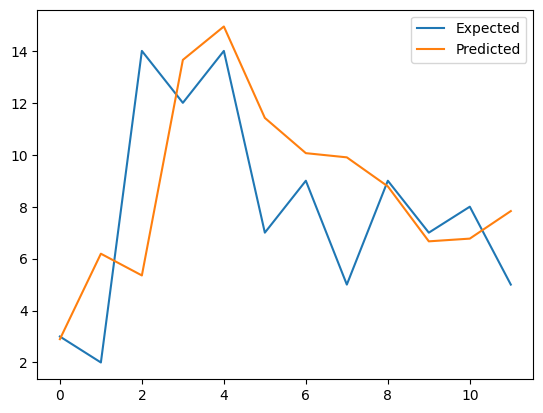

In [ ]:
# Evaluate
mae, y, yhat = walk_forward_validation(data, 12)
mape, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

# Resumen

Podemos observar que ambas métricas muestran un buen desempeño del modelo XGBoost a la hora de pronosticar el número de atascos en la ciudad de Medellín.